# Quanvolutional Neural Networks for Conspicuity Detection in Production


## Project overview
The project is about the applicability of quantum Computing to problems in industry and more specifically the project is about anomaly detection using quantum computers and how production processes in Industry can be improved with it. The aim of anomaly detection is to find a mathematical model adapted to the available data that detects and recognizes outliers. How can quantum computers help in the application of anomaly detection?

The industry is very interested in the development of such models because they have major impact on profitability. For example by identifying early signs of equipment failure, Companies can perform maintenance before a breakdown occurs 
and thus minimizing unplan downtime. Also preventing maintenance is typically less expensive than emergency repairs plus 
early detection of a anomalis helps to avoid costly breakdowns. So, detecting anomalies can prevent dangerous situations by identifying safety hazards before they lead to actual accidents.

The data we will be working with are images of manufactured parts that need to be checked of errors and our aim is to explore the extent to which Quantum Computing methods can support us in this task and as often industry relevant applications of quantum Computing are almost always hybrid applications that combine classical software and implementations of quantum circuits this means that classical algorithms and Quantum algorithms are used alternate so the classical algorithm generat data and this data serves as input for the construction of the quantum circuit and then the quantum algorithm generates an output which is passed to the classical algorithm and back and forth. This is the the typical scenario for industry applications.

we will use the Quantum neural networks. When working with machine learning models, the typical workflow is first we must
convert some classical data into a form that is suitable as input for a variational Quantum algorithm then a parameterized Quantum circuit is designed and implemented and finally you have to decide on a measurement procedure whose outcome encodes the result you're interested in. The task is a little difficult, because it's about trying out something which is more closely related to the real life industry use case. It's about developing your own model but the difficulty is that you have to think a lot about pre-processing the data. The data is available in the form of images. It's a non-trivial task to put them into a form that can be passed to a Quantum neural network, so this will be a major challenge to get this model running with the data available.

The project focuses on conspicuity detection in production, which makes it possible to identify improvement measures for individual work steps or sub-processes at an early stage and thus optimize the production process. To do this, we analyze process data such as image data or time series to uncover deviations and weak points in production. Classical methods for analyzing such data are very time-consuming.

Therefore, our project attempts to explore the potential of hybrid quantum computing in accelerating this process. Our primary focus lies in implementing the necessary hybrid quantum algorithms and rigorously benchmarking them against classical approaches, including machine learning and statistical methods. We are going to tackle QNNs (Quantum Neural Networks) with different scaling approaches. The goal is to implement these prototypes in these frameworks and present their results using standard metrics and visualization.

In this poject we implement the Quanvolutional Neural Network, a quantum machine learning model originally introduced in Henderson et al. (2019).

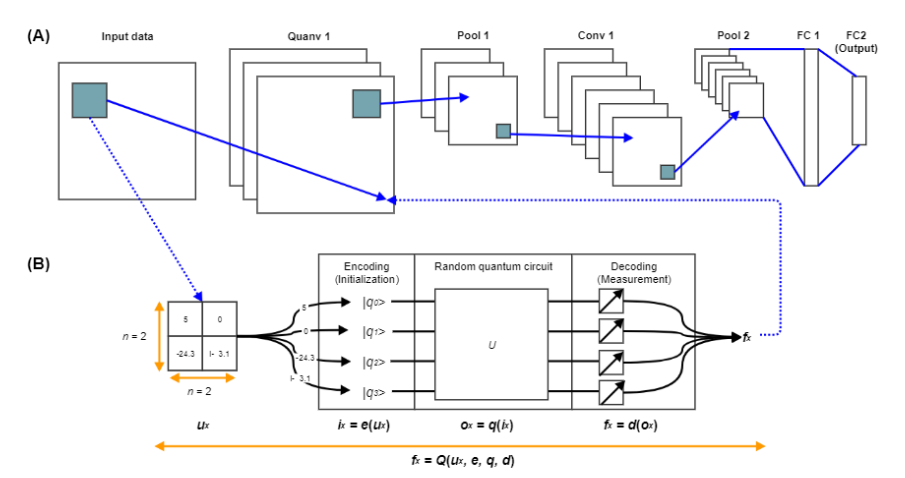

# Quanvolutional Neural Networks
## Introduction
### Classical convolution
Convolutional neural networks (CNNs) have rapidly risen in popularity for many machine learning applications, particularly in the field of image processing. Much of the benefit generated from these networks comes from their ability
to extract features from the data in a hierarchical manner. These features are extracted using various transformational
layers, notably the convolutional layer which gives the model its name.

The model is based on the idea of a convolution layer where, instead of processing the full input data with a global function, a local convolution is applied. If the input is an image, small local regions are sequentially processed with the same kernel. The results obtained for each region are usually associated to different channels of a single output pixel. The union of all the output pixels produces a new image-like object, which can be further processed by additional layers.
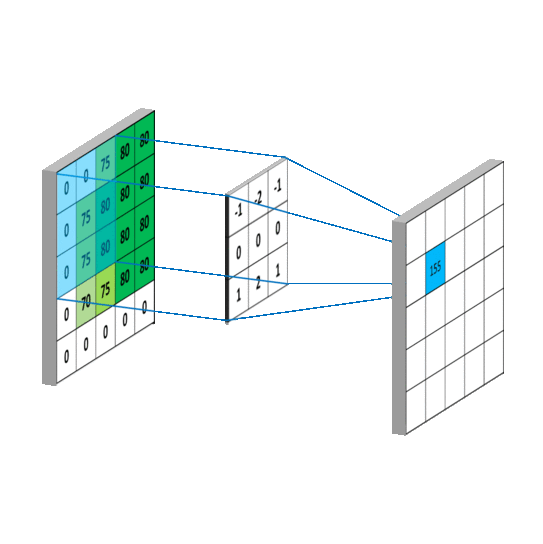
### Quantum convolution
QCNN is a new design of CNNs for multi-dimensional vectors using quantum circuits as convolutional filters. To fully leverage massively parallel computations on the superposition of quantum states with a limited number of qubits, QCNN is designed to mimic the role of CNN. To make QCNN operate as CNN, spatial information should be processed by the quantum circuit adequately. The quanvolution filter is the primary method to utilize spatial information. The quanvolutional filter consists of three components, i.e., encoder, parameterized quantum circuit (PQC), and measurement. By designing the filter with trainable parameters, the quanvolutional filter can be regarded as an extension of the filter in classical CNN. The architecture of quanvolutional filter is illustrated at the top of this project.

Quanvolutional layers operate on input data  by locally transforming the data using a number of random quantum circuits, in a way that is similar to the transformations performed by random convolutional filter layers. Provided these quantum transformations produce meaningful features for classification purposes, then the overall algorithm could be quite useful for near term quantum computing, because it requires small quantum circuits with little to no error correction. Quantum computers can access kernel functions in high dimensional Hilbert spaces much more efficiently than classical computers. So, the coverage will be faster.


The scheme is also represented in the figure at the top of this project. First, we build and train a non trainable Quanvolutional Neural Network with different angle encoding schemes (see the following figure). We then Compare the Quanvolutional Neural Network with a simple classic neural network model. 

Finally, we consider a 2x2 trainable quanvolutional filter (4 quanvolutional filter with stride 1) with non-random quantum circuit (appropriate Ansatz) and compare with a classic neural network model.


We implement a Quantum Machine Learning model to detect a defective production part. The implementation includes the preprocessing of the data, the implementation of a model and the visualization of the results. We use only a subset of the downloaded data. 


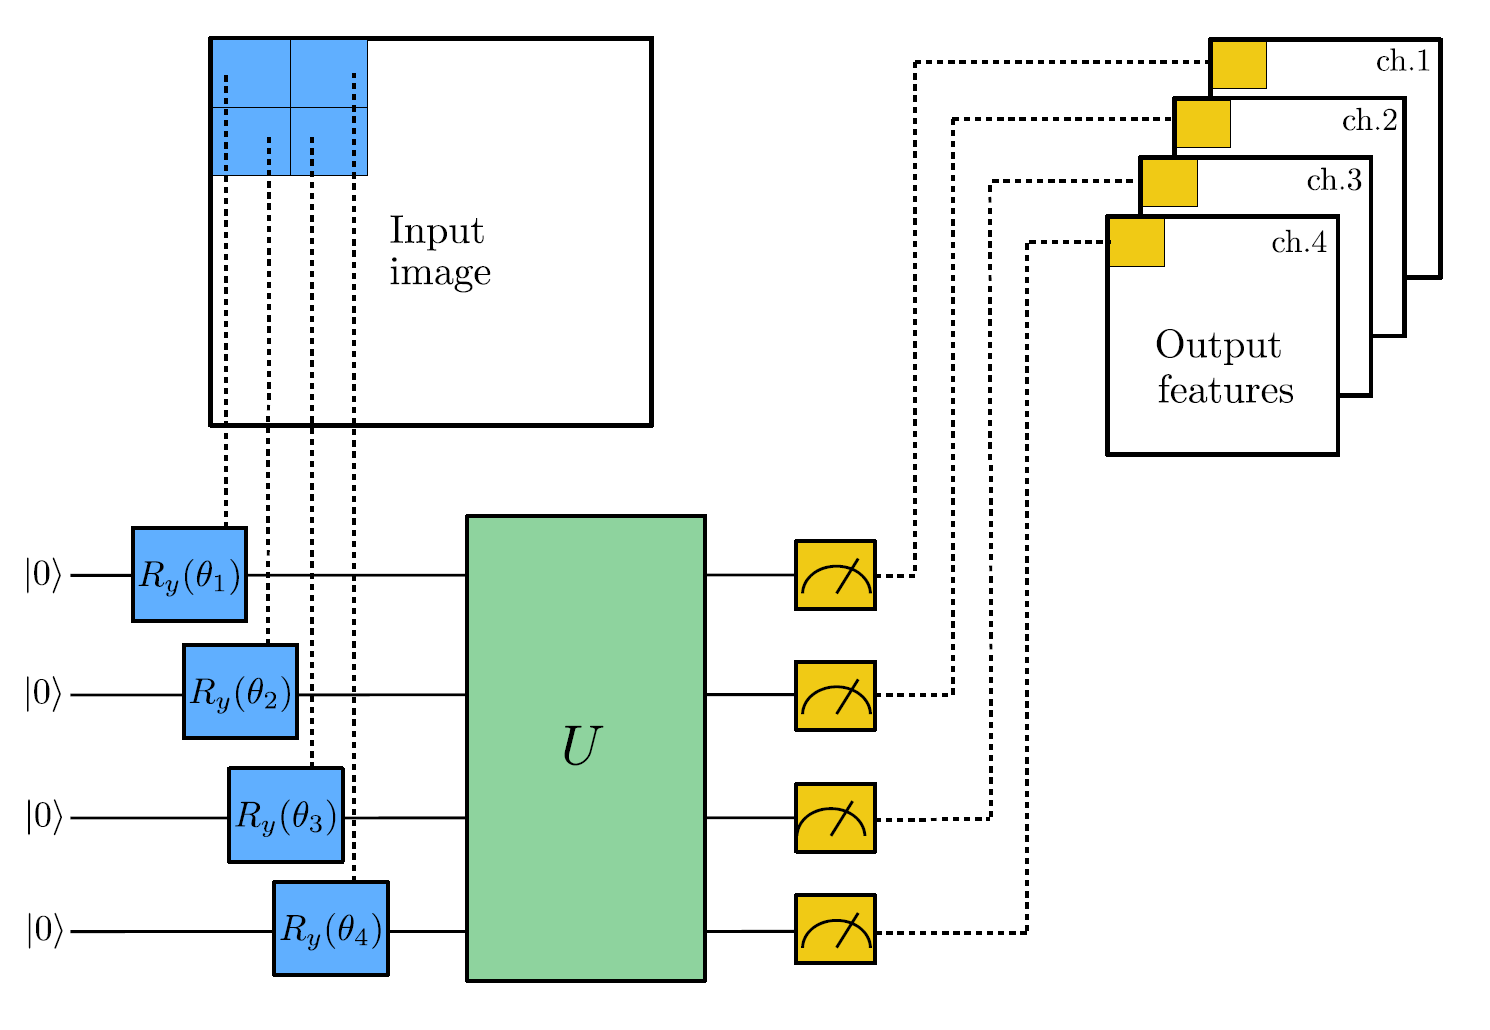

In this project, first we consider a fixed non-trainable quantum circuit used as a “quanvolution” kernel, while the subsequent classical layers are trained for the classification problem. Second, by using the ability of PennyLane to evaluate gradients of quantum circuits, the quantum kernel could also be trained. So, we consider the case that quanvolutional filters are trainable.
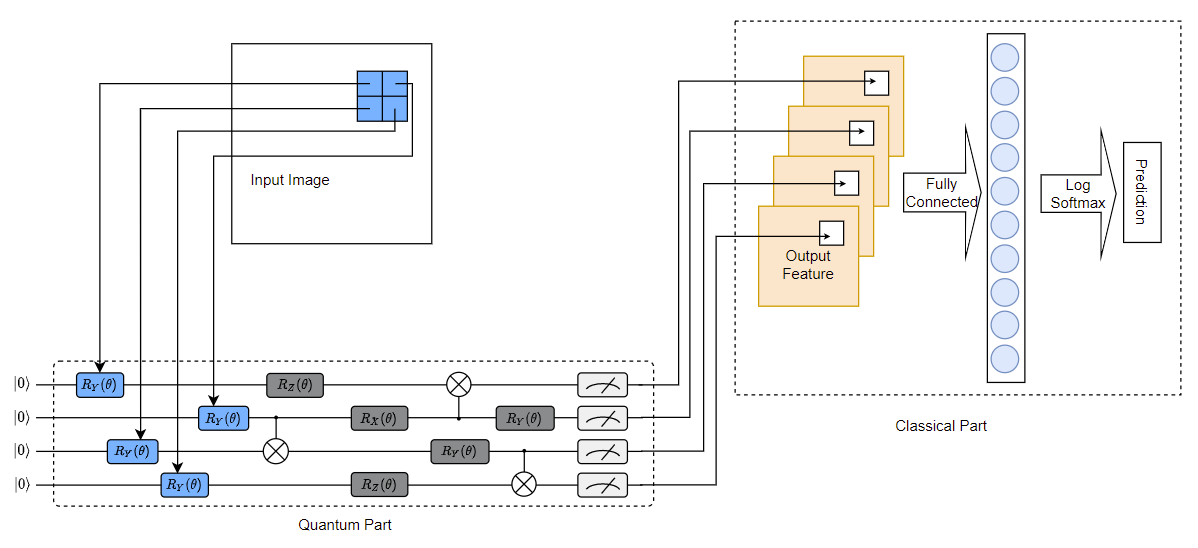

## Importing the necessary libraries
We use PennyLane with the TensorFlow interfaces, also we need the plotting library matplotlib for visualization of the results. 

In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import json
import os
from PIL import Image
import random
from typing import List, Tuple 
import types, math

## Setting of the main hyper-parameters of the model

In [3]:
n_epochs = 50   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 500   # Size of the train dataset
n_test = 100     # Size of the test dataset

SAVE_PATH = "C:/Users/HAMID/github/Quantum Computing"  # Data saving folder
PREPROCESS = True        # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

## 1- Loading of the TIG-aluminium-5083 dataset
We download the TIG-aluminium-5083 dataset from kaggle. To speedup the execuation we import only a small number of training and test images. Obviously, better results are achievable when using the full dataset.

In [4]:
train_json = 'C:/Users/HAMID/github/Quantum Computing/Pennylane/al5083/train/train.json'

with open(train_json, 'r') as json_file:
    train_data_json = json.load(json_file)

The TIG-aluminium-5083 dataset has 6 classes including "Good weld", "Burn through", "Contamination", "Lack of fusion", "Misalignment", "Lack of penetration". We perform one_hot_encoding for labels to have more insight about dataset. 

In [5]:
label_names = ["Good weld", "Burn through", "Contamination", "Lack of fusion", "Misalignment", "Lack of penetration"]
labels = [0, 1, 2, 3, 4, 5]
one_hot_encoding = tf.keras.utils.to_categorical(labels, num_classes=6)
label_count = [0, 0, 0, 0, 0, 0]

In [6]:
for l in train_data_json:
    label_count[train_data_json[l]] += 1
    
label_count

[8758, 1783, 6325, 4028, 2953, 2819]

The dataset is clearly imbalance where a perfect balance implies equal weightage to all classes i.e 100/6 = 16.6 % about 2000 labels per class.

In [7]:
all_data = []
image_size = (32, 32)
label_count = [0, 0, 0, 0, 0, 0]

In [8]:
def load_data(path):
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if(os.path.isdir(folder_path)):
            for img_name in os.listdir(folder_path):
                
                img_path = os.path.join(folder_path, img_name)
                key_name = folder + '/' + img_name
                label = train_data_json[key_name]
                
                if(label_count[label] > 2000): # blancing dataset 
                    continue
                    
                label_count[label] += 1
                image = Image.open(img_path).resize(image_size)
                image = tf.convert_to_tensor(image)
                all_data.append((image, label))
                
                if(len(all_data)%100==0):
                    print(f"Total images loaded : {len(all_data)}, Label count : {label_count}", end = '\r')

In [9]:
load_data('C:/Users/HAMID/github/Quantum Computing/Pennylane/al5083/train')

In [10]:
random.shuffle(all_data)   # shuffle dataset 

In [11]:
X = []
y = []
for data in all_data:
    X.append(data[0])  # images
    y.append(data[1])  # labels


In [12]:
rand_num = np.random.randint(low = 0, high = len(all_data))
X[rand_num], y[rand_num]

(<tf.Tensor: shape=(32, 32), dtype=uint8, numpy=
 array([[11,  0,  1, ..., 31, 31, 32],
        [15,  2,  2, ..., 33, 32, 32],
        [20,  8,  2, ..., 33, 32, 32],
        ...,
        [50, 51, 51, ..., 49, 51, 51],
        [48, 48, 47, ..., 48, 48, 50],
        [46, 44, 46, ..., 46, 46, 48]], dtype=uint8)>,
 0)

Representing some random images with labels

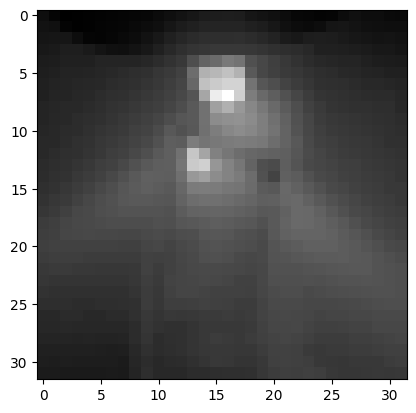

Label : Misalignment


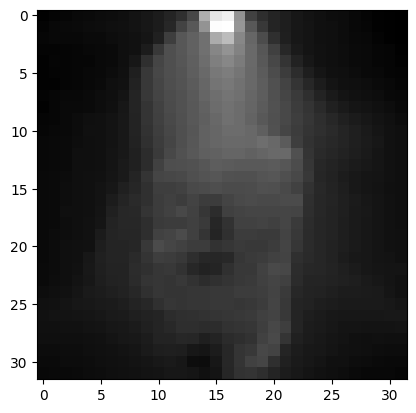

Label : Contamination


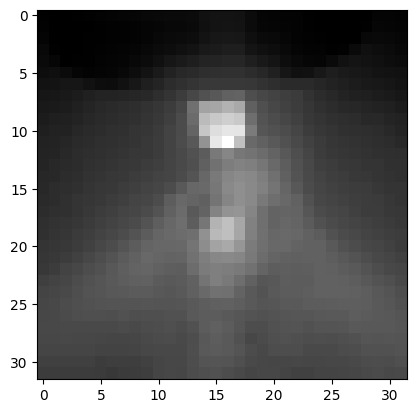

Label : Lack of penetration


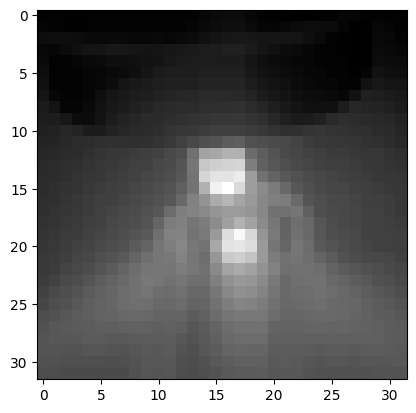

Label : Lack of penetration


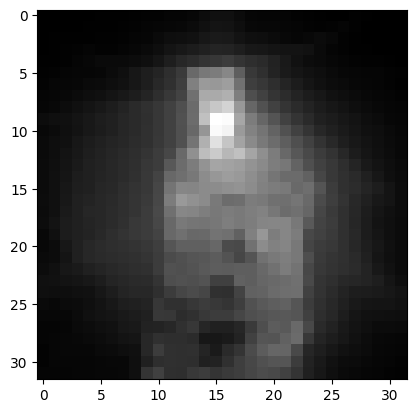

Label : Contamination


In [13]:
for _ in range(5):
    rand_img = np.random.randint(low = 0, high = len(X))
    plt.imshow(X[rand_img], cmap='gray')
    plt.show()
    print(f"Label : {label_names[y[rand_img]]}")

spliting train and test dataset (80% train data & 20% test data) 

In [14]:
total_data = len(X)
X_train, y_train = X[:int(total_data*0.8)] , y[:int(total_data*0.8)]
X_test, y_test = X[int(total_data*0.8):] , y[int(total_data*0.8):]

In [15]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
      

Add extra dimension for convolution channels

In [16]:
X_train = np.array(X_train[..., tf.newaxis], requires_grad=False)
X_test = np.array(X_test[..., tf.newaxis], requires_grad=False)

Reduce dataset size

In [17]:
train_images =  X_train[:n_train,:,:,:]
test_images = X_test[:n_test,:,:,:] 

train_labels = y_train[:n_train]
test_labels = y_test[:n_test]


In [18]:
train_images.shape, test_images.shape, train_labels.shape, test_labels.shape

((500, 32, 32, 1), (100, 32, 32, 1), (500,), (100,))

# 2- Pre-processing
## Quantum data encoding

Many machine learning techniques transform input data X into a different space to make it easier to work with. This transformation $ φ : X → X ′ $ is often called a feature map. In quantum computing, the same analogy can be applied to perform a quantum feature map, which acts as $ φ : X → H$ where the vector space H is a Hilbert space. In fact, such feature mapping is mandatory when one uses quantum machine learning on classical data, since classical data must be encoded as a quantum state. 

The quantum feature map $ x ∈ X → |φ(x)〉 ∈ H$ is equivalent to applying a unitary transformation $Uφ(x) $ to the initial state $|0〉^{⊗n} $ to produce $ Uφ(x) |0〉^{⊗n} = |φ(x)〉$, where n is the number of qubits.

In this project, we develope two encoding methods:
### Qubit encoding
The qubit encoding embeds one classical data point xi, that is rescaled to lie between 0 and π, into a single qubit as     $ |φ(xi)〉 = \cos(\frac{xi}{2}) |0〉 + \sin(\frac{xi}{2}) |1〉$ for i = 1, ..., N . Hence, the qubit encoding maps input data of $ x = (x1, . . . , xN )^T $ to N qubits as

$$ Uφ(x) : x ∈ R^N → |φ(x)〉=\otimes_{i=1}^N(\cos(\frac{x_i}{2}) |0〉 +\sin(\frac{x_i}{2}) |1〉) $$

where $x_i ∈ [0, π)$ for all i. 

The encoding circuit can be expressed with a unitary operator $ Uφ(x) = ⊗^N_{j=1} Ux_j$ where

$$ Ux_j = e^{−i\frac{x_j}{2}σy} := \begin{bmatrix}\cos(\frac{x_j}{2}) & -\sin(\frac{x_j}{2}) \\ \sin(\frac{x_j}{2}) & \cos(\frac{x_j}{2}) \end{bmatrix} = R_y(x_j)   $$

### Dense qubit encoding
In principle, since a quantum state of one qubit can be described with two real-valued parameters, two classical data points can be encoded in one qubit. Thus the qubit encoding described above can be generalized to encode two classical vectors per qubit by using rotations around two orthogonal axes. By choosing them to be the x and y axes of the Bloch sphere, this method, which we refer to as dense qubit encoding, encodes $x_j = (x_{j1} , x_{j2} )$ into a single qubit as

$$ |φ(x_j )〉 = e^{−i \frac{x_{j2}}{2} σy}\: e^{−i \frac{x_{j1}}{2} σx}\:|0〉 =\: R_y(x_{j2})\: R_x(x_{j1}) \:|0〉 $$ .

Hence, the dense qubit encoding maps an N -dimensional input data $x = (x_1, . . . , x_N )^T $ to $\frac{N}{2}$ qubits as

$$ Uφ(x) : x ∈ R^N → |φ(x)〉= \: ⊗^{\frac{N}{2}}_{j=1} (e^{−i \frac{x_{N/2+j}}{2} σy} \; e^{−i \frac{x_{j}}{2} σx}\: |0〉) $$

There is freedom to choose which pair of classical data to be encoded in one qubit.

## Quantum circuit as a convolution kernel
Quanvolutional filter (Q) is denoted as U (θ) which is a randomly constructed quantum circuit includes 2 - qubits gate: CN OT , SW AP , ... and a random number of 1 - qubit gate: RX , RY , RZ , H, ... These gates also have random parameters (if it have). The order of selected gates in the circuit is shuffled and the final ordering of gate operations becomes one quanvolutional filter. This way is not based on any theorem so the high probability is not the optimized structure. Some proposed structures will be present in the Methodology section. The quantum circuit is applied to the initialized state       |ψ(xi)〉, now is U (θ)|ψ(xi)〉.

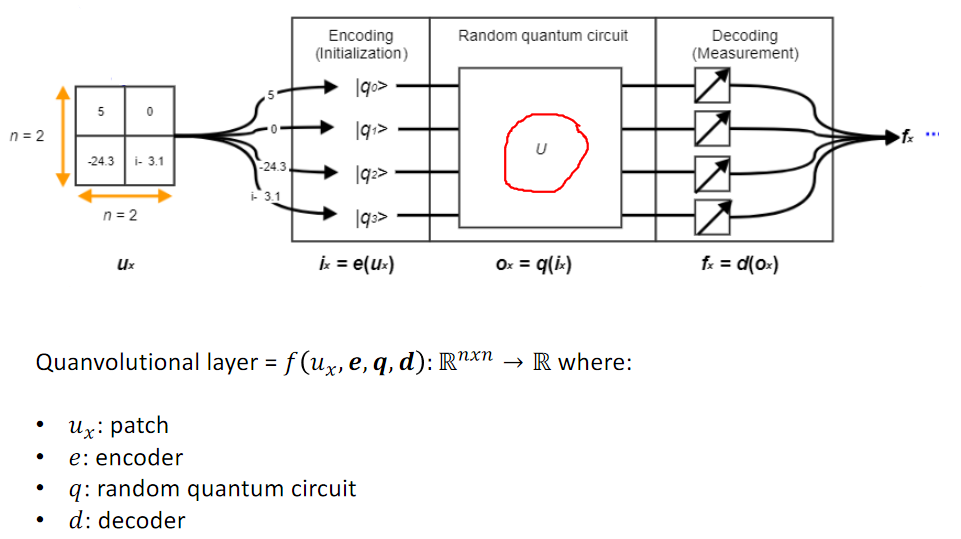
We follow the scheme described in the introduction and use two encoding approachs.

We initialize a PennyLane default.qubit device, simulating a system of arbitrary n qubits. We implement two quantum circuits with different encoding schemes. 

First quantum circuit consisting of:

1- an embedding layer using Qubit encoding including local Ry rotations (with angles scaled by a factor of π);

2- a random circuit of _n_layers_;

3- a final measurement in the computational basis, estimating n_qubit expectation values.

Second quantum circuit consisting of:

1- an embedding layer using dense qubit encoding including local Rx and Ry rotations (with angles scaled by a factor of π).
   The dense qubit encoding maps an N -dimensional input data to 𝑁/2 qubits;

2- a random circuit of _n_layers_;

3- a final measurement in the computational basis, estimating $(\frac{n\:qubit}{2})$ expectation values.

In [32]:
quanv_num_filter = 4
quanv_size_filter = 2   # this would correspond to a convolution with a (quanv_size_filter × quanv_size_filter) kernel
stride_filter = 1        # This process reduces the resolution of the input image

Dense_qubit_Encoding = True       # If True, perform the dense_qubit_Encoding 

kernel_size =  quanv_size_filter
n_qubit = kernel_size**2         # for qubit encoding quantum circuit
n_dense = int(n_qubit/2)         # for dense qubit encoding quantum circuit


## Convolution kernel using Qubit encoding

In [33]:
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, n_qubit))

dev = qml.device("default.qubit", wires=n_qubit)
        
@qml.qnode(dev)
def circuit_qubit_encoding(phi):
    # Encoding of kernel_size**2 classical input values
    for j in range(n_qubit):
        qml.RY(np.pi * float(phi[j])/255 , wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(n_qubit)))

    # Measurement producing n_qubit classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(n_qubit)]


## Convolution kernel using Dense qubit encoding

In [34]:
# Random circuit parameters

rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, n_dense))

dev = qml.device("default.qubit", wires=n_dense)

@qml.qnode(dev)
def circuit_dense_qubit_encoding(phi):
    # Encoding of kernel_size**2 classical input values
    for j in range(n_dense):
        qml.RX(np.pi * float(phi[j])/255 , wires=j)
        qml.RY(np.pi * float(phi[j+n_dense])/255 , wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(n_dense)))

    # Measurement producing n_dense classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(n_dense)]

The next function defines the convolution scheme:

1- The image is divided into squares of kernel_size×kernel_size pixels;

2- Each square is processed by the quantum circuit;

3- The $(kernel\:size)^2$ expectation values are mapped into $(kernel\:size)^2$ different channels of a single output pixel.



In [35]:
# Number of output channels based on the type of encoding
if Dense_qubit_Encoding == False:
    channels_num = quanv_num_filter
else:
    channels_num = int(quanv_num_filter/2)

In [36]:
def quanv_filter(image):
    
    n_image = image.shape[0]
    kernel_size = quanv_size_filter
              
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((n_image // kernel_size, n_image // kernel_size, channels_num))
    
    # Loop over the coordinates of the top-left pixel of (kernel_size)x(kernel_size) squares
    for i in range(0, n_image, stride_filter):
        for j in range(0, n_image, stride_filter):
            phi = []
            # Padding not yet implemented
            if(i+ kernel_size > n_image) | (j+ kernel_size > n_image):
                continue
            for l in range(i,i+ kernel_size): 
                for m in range(j,j+ kernel_size):
                    phi.append(image[l,m,0])
                    
            if Dense_qubit_Encoding == False:
                q_results = circuit_qubit_encoding(phi)
            else:
                q_results = circuit_dense_qubit_encoding(phi)               
                      
            # Assign expectation values to different channels of the output pixel (i/kernel_size, j/kernel_size)
            for c in range(channels_num):
                out[i // kernel_size, j // kernel_size, c] = q_results[c]
               
    return out

## Quantum pre-processing of the dataset
Since we are not going to train the quantum convolution layer, it is more efficient to apply it as a “pre-processing” layer to all the images of our dataset. Later an entirely classical model will be directly trained and tested on the pre-processed dataset, avoiding unnecessary repetitions of quantum computations.

The pre-processed images will be saved in the folder SAVE_PATH. Once saved, they can be directly loaded by setting PREPROCESS = False, otherwise the quantum convolution is evaluated at each run of the code.

In [37]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        #print(idx, img[1, 10,0])
        q_train_images.append(quanv_filter(img))
        #print(quanv(img).shape)
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv_filter(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
500/500        
Quantum pre-processing of test images:


In [38]:
q_train_images.shape, q_test_images.shape, train_labels.shape,test_labels.shape

((500, 16, 16, 2), (100, 16, 16, 2), (500,), (100,))

Let us visualize the effect of the quantum convolution layer on a batch of samples:

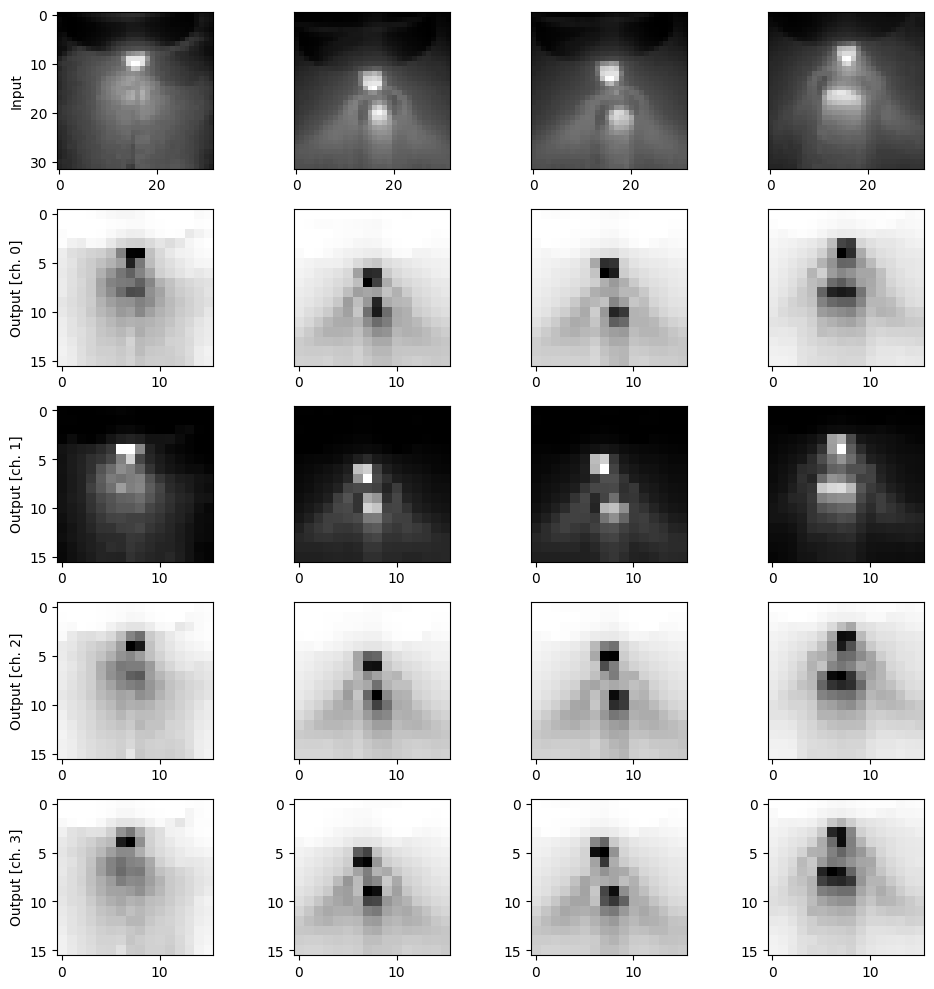

In [26]:
n_samples = 4
n_channels = channels_num
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

## Below each input image, the n_channels output channels generated by the quantum convolution are visualized in gray scale.

One can clearly notice the downsampling of the resolution and some local distortion introduced by the quantum kernel. On the other hand the global shape of the image is preserved, as expected for a convolution layer.

### Hybrid quantum-classical model
After the application of the quantum convolution layer we feed the resulting features into a classical neural network that will be trained to classify the 6 different Conspicuity labels in Production of the dataset.

To show efficiency of quantum convolution layer, We use a simple model: two fully connected layer (Dense layers). The first  Dense layer has 1024 outputs with 'relu' activation function, the final layer has 6 output nodes with a final softmax activation function.

The model is compiled with a Adam optimizer, and a sparse-cross-entropy loss function.
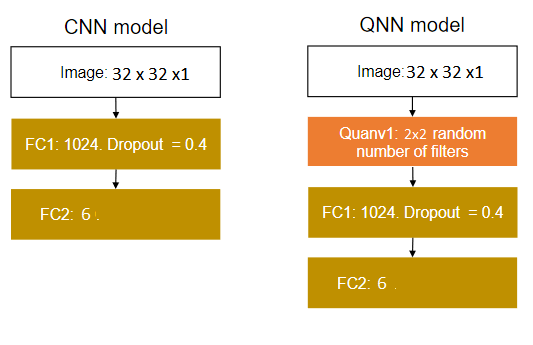


In [39]:
from tensorflow.keras import layers

def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
              
        
        keras.layers.Flatten(),
        
        keras.layers.Dense(1024, activation="relu"),
        keras.layers.Dropout(0.4),
        
        keras.layers.Dense(len(labels), activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy", 
        metrics=["accuracy"],
    )
    return model



## Training
We first initialize an instance of the model, then we train and validate it with the dataset that has been already pre-processed by a quantum convolution.

In [40]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images, train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)
print(q_model.summary())

Epoch 1/50
125/125 - 2s - loss: 1.9250 - accuracy: 0.3160 - val_loss: 1.6517 - val_accuracy: 0.4400 - 2s/epoch - 18ms/step
Epoch 2/50
125/125 - 1s - loss: 1.3704 - accuracy: 0.4680 - val_loss: 1.4287 - val_accuracy: 0.4800 - 1s/epoch - 8ms/step
Epoch 3/50
125/125 - 1s - loss: 1.1227 - accuracy: 0.6240 - val_loss: 0.8951 - val_accuracy: 0.7500 - 1s/epoch - 8ms/step
Epoch 4/50
125/125 - 1s - loss: 0.9473 - accuracy: 0.6580 - val_loss: 0.7453 - val_accuracy: 0.7800 - 1s/epoch - 8ms/step
Epoch 5/50
125/125 - 1s - loss: 0.8552 - accuracy: 0.7000 - val_loss: 0.5915 - val_accuracy: 0.8400 - 934ms/epoch - 7ms/step
Epoch 6/50
125/125 - 1s - loss: 0.7202 - accuracy: 0.7560 - val_loss: 0.5218 - val_accuracy: 0.8300 - 1s/epoch - 8ms/step
Epoch 7/50
125/125 - 1s - loss: 0.7016 - accuracy: 0.7440 - val_loss: 0.5452 - val_accuracy: 0.8100 - 949ms/epoch - 8ms/step
Epoch 8/50
125/125 - 1s - loss: 0.5850 - accuracy: 0.7900 - val_loss: 0.4790 - val_accuracy: 0.8900 - 934ms/epoch - 7ms/step
Epoch 9/50
125

In order to compare the results achievable with and without the quantum convolution layer, we initialize also a “classical” instance of the model that will be directly trained and validated with the raw dataset (i.e., without quantum pre-processing).

In [41]:
c_model = MyModel()

c_history = c_model.fit(
    train_images/255.0,
    train_labels,
    validation_data=(test_images/255.0, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/50
125/125 - 3s - loss: 1.5829 - accuracy: 0.4060 - val_loss: 1.6485 - val_accuracy: 0.3600 - 3s/epoch - 25ms/step
Epoch 2/50
125/125 - 2s - loss: 1.1037 - accuracy: 0.6000 - val_loss: 1.1003 - val_accuracy: 0.6800 - 2s/epoch - 14ms/step
Epoch 3/50
125/125 - 2s - loss: 0.8267 - accuracy: 0.7100 - val_loss: 0.5930 - val_accuracy: 0.8400 - 2s/epoch - 14ms/step
Epoch 4/50
125/125 - 2s - loss: 0.6344 - accuracy: 0.7680 - val_loss: 0.5134 - val_accuracy: 0.8000 - 2s/epoch - 14ms/step
Epoch 5/50
125/125 - 2s - loss: 0.5660 - accuracy: 0.8200 - val_loss: 0.3730 - val_accuracy: 0.9300 - 2s/epoch - 13ms/step
Epoch 6/50
125/125 - 2s - loss: 0.4921 - accuracy: 0.8200 - val_loss: 0.3432 - val_accuracy: 0.9200 - 2s/epoch - 13ms/step
Epoch 7/50
125/125 - 2s - loss: 0.4536 - accuracy: 0.8380 - val_loss: 0.3437 - val_accuracy: 0.8700 - 2s/epoch - 14ms/step
Epoch 8/50
125/125 - 2s - loss: 0.4291 - accuracy: 0.8540 - val_loss: 0.3215 - val_accuracy: 0.8900 - 2s/epoch - 14ms/step
Epoch 9/50
125/1

## Visualizing the Results
We can finally plot the test accuracy and the test loss with respect to the number of training epochs.

C:\Users\HAMID\AppData\Local\Temp\ipykernel_1960\2231007003.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


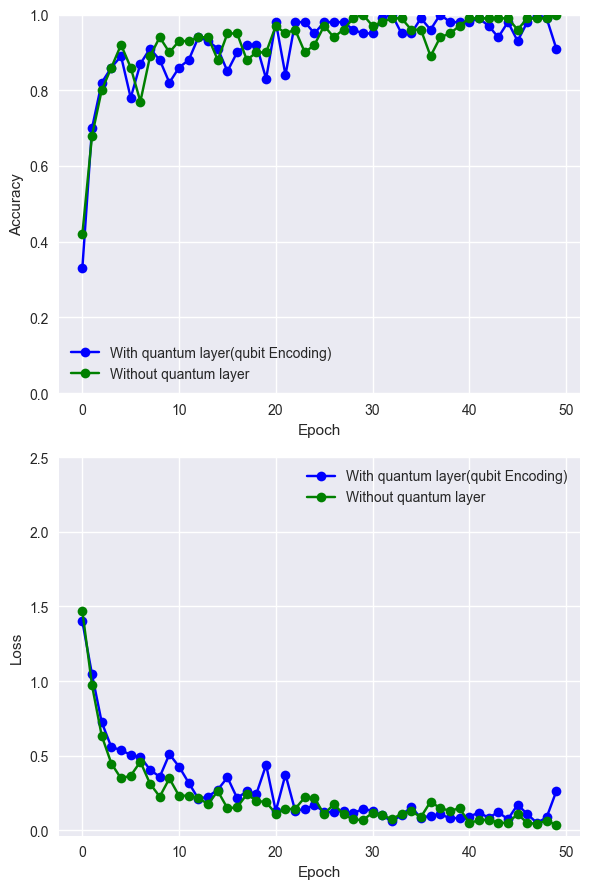

In [30]:
import matplotlib.pyplot as plt

if Dense_qubit_Encoding == False:
    
    plt.style.use("seaborn")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

    ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer(qubit Encoding)")
    ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
    ax1.set_ylabel("Accuracy")
    ax1.set_ylim([0, 1])
    ax1.set_xlabel("Epoch")
    ax1.legend()


    ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer(qubit Encoding)")
    ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")   
    ax2.set_ylabel("Loss")
    ax2.set_ylim(top=2.5)
    ax2.set_xlabel("Epoch")
    ax2.legend()
    plt.tight_layout()
    plt.show()

C:\Users\HAMID\AppData\Local\Temp\ipykernel_1960\2161022943.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


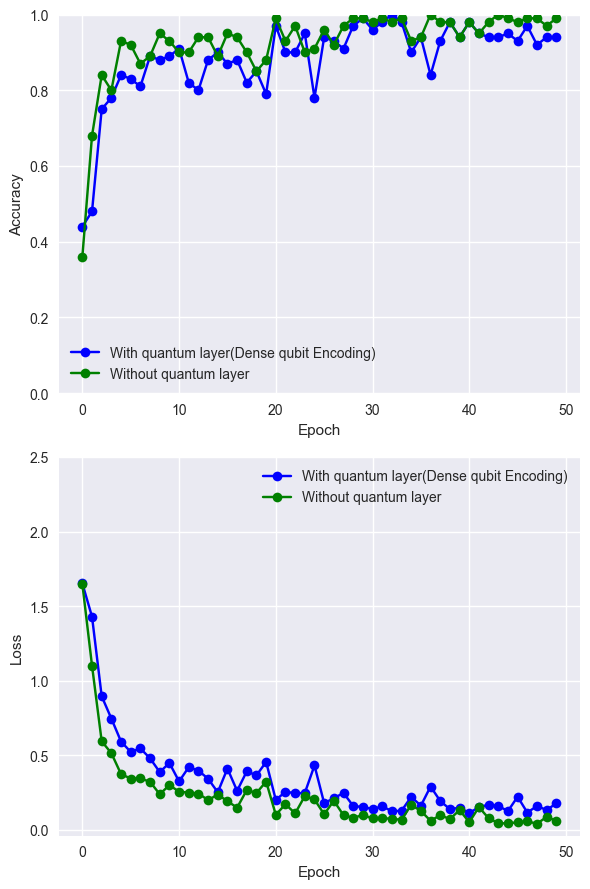

In [42]:
import matplotlib.pyplot as plt

if Dense_qubit_Encoding == True:
    
    plt.style.use("seaborn")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

    ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer(Dense qubit Encoding)")
    ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
    ax1.set_ylabel("Accuracy")
    ax1.set_ylim([0, 1])
    ax1.set_xlabel("Epoch")
    ax1.legend()

    ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer(Dense qubit Encoding)")
    ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")    
    ax2.set_ylabel("Loss")
    ax2.set_ylim(top=2.5)
    ax2.set_xlabel("Epoch")
    ax2.legend()
    plt.tight_layout()
    plt.show()

## Trainable Quanvolutional Filter
In this section, we consider the case that quanvolutional filters are trainable, and we compare two models with nearly the same number of trainale parameters. The two models compared here are described by the following figure.

The Model1 contains a trainable quanvolutional filter and a fully connected layer. The Model2 is two fully connected layers.

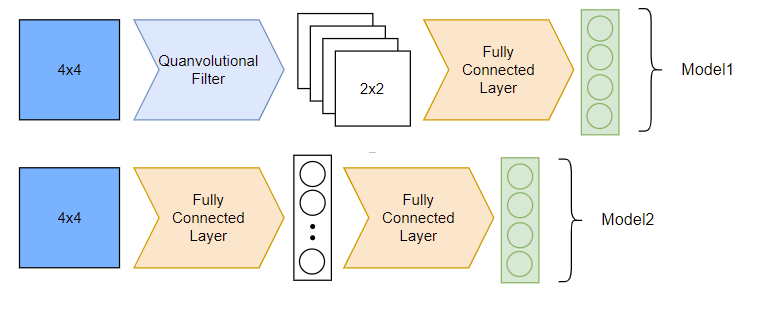

A trainable version of Quanvolutional Neural Networks using parametrized Random Circuits was implemented in [3]. As mentioned, due to the randomized circuits, training process is challenging and might take for some randomly generated circuits quite long, while other random circuits seem to be more suitable. For more stable results we are going to use appropriate ansatz circuits instead of randomly generated ones. We employ the ansatzs introduced in [4] based on expressibility and entangling capability of parameterized quantum circuits for hybrid quantum-classical algorithms as follows:

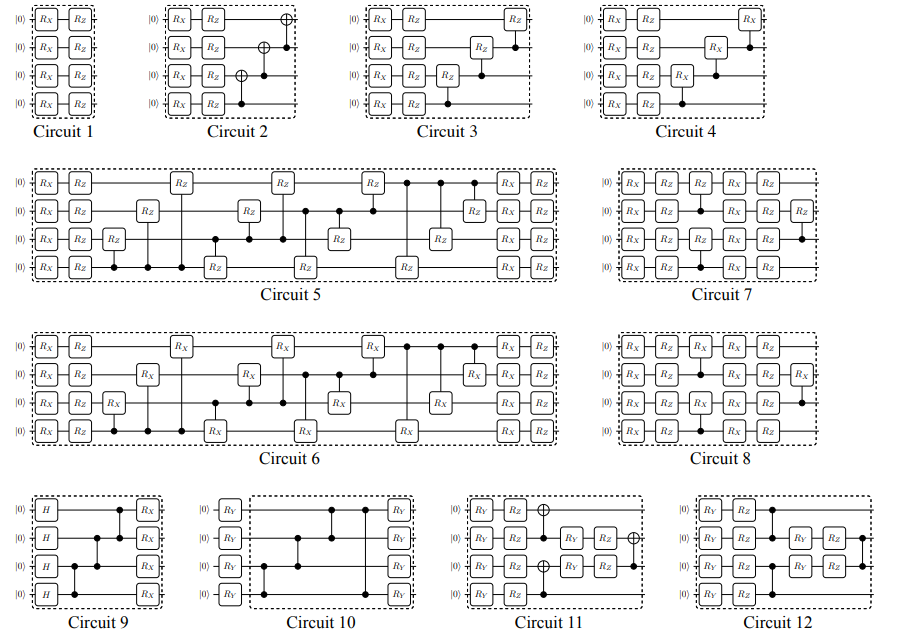

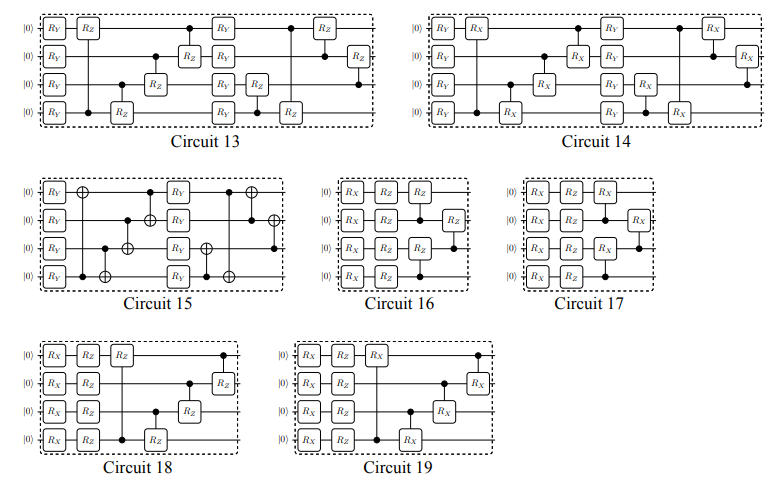
A set of circuit templates considered in the study, each labeled with a circuit ID. The dashed box indicates a single circuit layer.

As mentioned in [4], the circuits 6 and 14 have the best expressibility and acceptable entangling capability, but the circuit 14 has lower depth (circuit depth = 10) and 16 parameters. We select cuircuit 14 as ansatz Trainable Quanvolutional Filter.

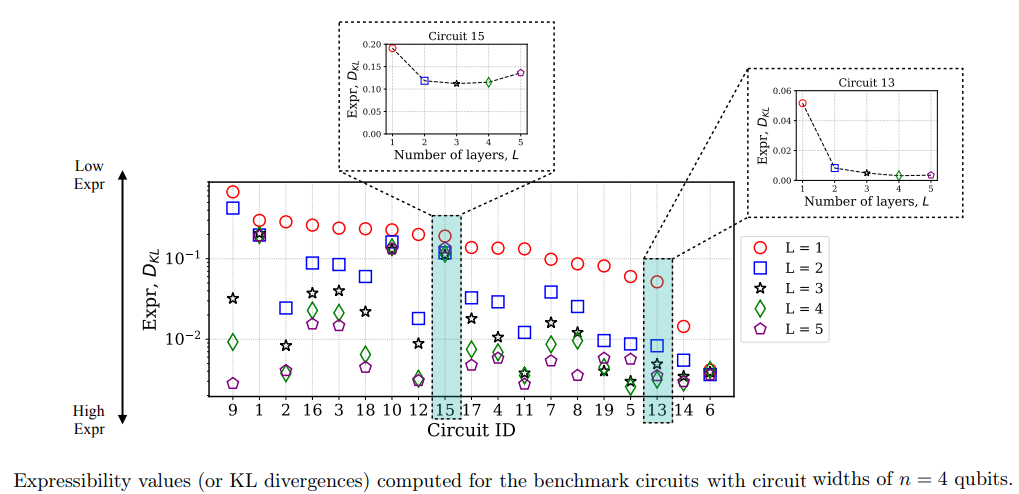

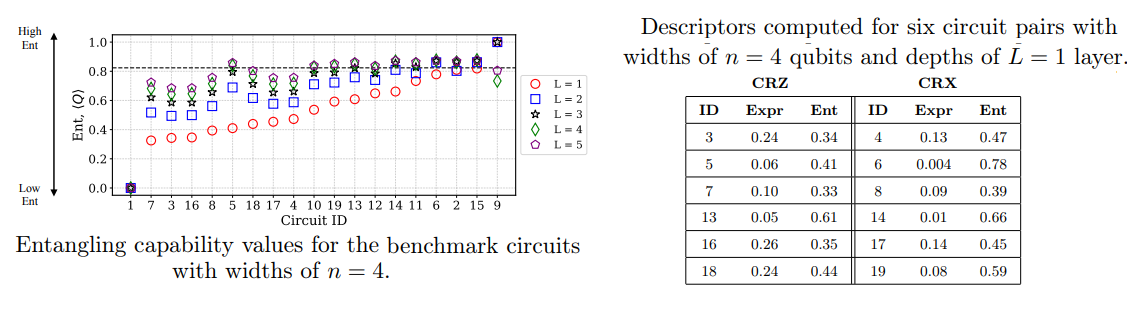

Also, we consider the circuit configurations of two-qubit operations. Recent hardware developments allow for
more complex qubit topologies, e.g. nearest-neighbor interactions on a two-dimensional lattice or all-to-all qubit
interactions, depending on the architecture. To investigate the potential advantages of these qubit topologies,
three configurations of two-qubit gates were compared: nearest-neighbor (NN), circuit-block (CB), and all-to-all
(AA) configurations. The NN configuration is a natural arrangement of two-qubit operations on a linear array of
qubits. The CB configuration is a natural arrangement for an array of qubits that form a closed loop. The AA
configuration assumes a fully connected graph arrangement of qubits.

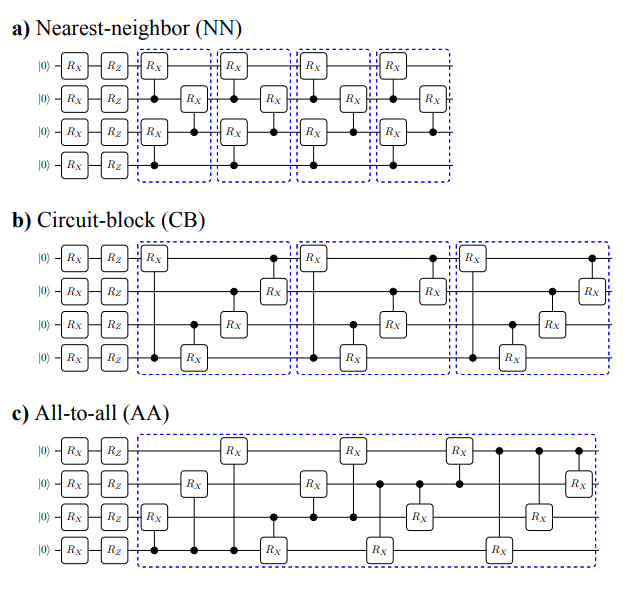

Both expressibility and entangling capability were computed, as shown in the following Table.

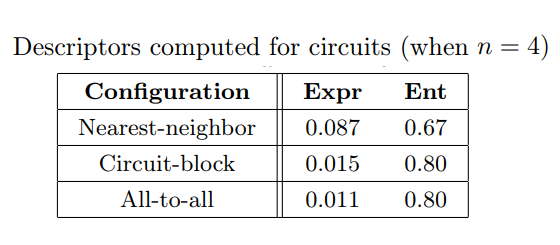
The use of an all-to-all configuration led to both favorable expressibility and entangling capability scores but with a trade-off in the number of parameters, circuit depth, and qubit connectivity requirements. The use of the circuit block architecture led to relatively favorable expressibility and entangling capability, offering a cheaper or more near-term circuit structure alternative.

Also, we choose CB configuration as ansatz Trainable Quanvolutional Filter. 

In [43]:
import tf_keras as keras
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import matplotlib.pyplot as plt
from tf_keras import layers, models
from PIL import Image
import random
from typing import List, Tuple 
import types, math
import tensorflow as tf

## Quanvolutional Layer using Circuit ID = 14

In [44]:
class QuanvLayer_circuit14(keras.layers.Layer):
    def __init__(self, stride=2, device="default.qubit", wires=4, circuit_layers=1, n_rotations=16, out_channels=4):
        super(QuanvLayer_circuit14, self).__init__()
        
        # init device
        self.wires = wires
        self.dev = qml.device(device, wires=self.wires)
        
        self.stride = stride
        self.out_channels = min(out_channels, wires)
        
            
        # Parameterized Quantum circuits
        @qml.qnode(device=self.dev)
                
        def circuit(inputs, weights):
            
            n_inputs=4
            # Encoding of 4 classical input values
            for j in range(n_inputs):
                qml.RY(np.pi * float(inputs[j])/255, wires=j)
            
                                          
            # Quantum circuit 14
            for i in range(n_inputs):
                qml.RY(weights, wires=i)
                
            qml.CRX(weights, wires=[3, 0])
            qml.CRX(weights, wires=[2, 3])
            qml.CRX(weights, wires =[1,2])
            qml.CRX(weights, wires =[0,1])
            
            qml.RY(weights, wires =0)
            qml.RY(weights, wires =1)
            qml.RY(weights, wires =2)
            qml.RY(weights, wires =3)
            
            qml.CRX(weights, wires =[3,2])
            qml.CRX(weights, wires =[0,3])
            qml.CRX(weights, wires =[1,0])
            qml.CRX(weights, wires =[2,1])
                        
            # Measurement producing 4 classical output values
            return [qml.expval(qml.PauliZ(j)) for j in range(self.out_channels)]
        
        weight_shapes = {"weights": [n_rotations]}
        self.circuit = qml.qnn.KerasLayer(circuit, weight_shapes = weight_shapes, output_dim = out_channels)  
        
        
           
    def draw(self):
        # build circuit by sending dummy data through it
        drawer = qml.draw_mpl(self.circuit)
        print(drawer(inputs=tf.convert_to_tensor(np.zeros(4))))
        
        

    def call(self, img):
        h, w, ch = img.shape
        if ch > 1:
            img = img.mean(axis=-1).reshape(h, w, 1)
                        
        kernel_size = 2        
        h_out = (h-kernel_size) // self.stride + 1
        w_out = (w-kernel_size) // self.stride + 1
        
        
        out = np.zeros((h_out, w_out, self.out_channels))
        
        # Loop over the coordinates of the top-left pixel of 2X2 squares
        for j in range(0, h_out, self.stride):
            for k in range(0, w_out, self.stride):
                # Process a squared 2x2 region of the image with a quantum circuit
                q_results = self.circuit(tf.convert_to_tensor(
                    [
                        img[j, k, 0],
                        img[j, k + 1, 0],
                        img[j + 1, k, 0],
                        img[j + 1, k + 1, 0]
                        ])
                                         )
                
                # Assign expectation values to different channels of the output pixel (j/2, k/2)
                for c in range(self.out_channels):
                    out[j // kernel_size, k // kernel_size, c] = q_results[c]
                
        return out
  

In [45]:
# Test QuanvLayer

quanv = QuanvLayer_circuit14(circuit_layers=1, n_rotations=16, out_channels=4, stride=2)

x = np.random.rand(32,32,1)
print(x.shape)
# Check OonvLayer Output shape
quanv(x).shape

(32, 32, 1)


(16, 16, 4)

(<Figure size 1300x500 with 1 Axes>, <Axes: >)


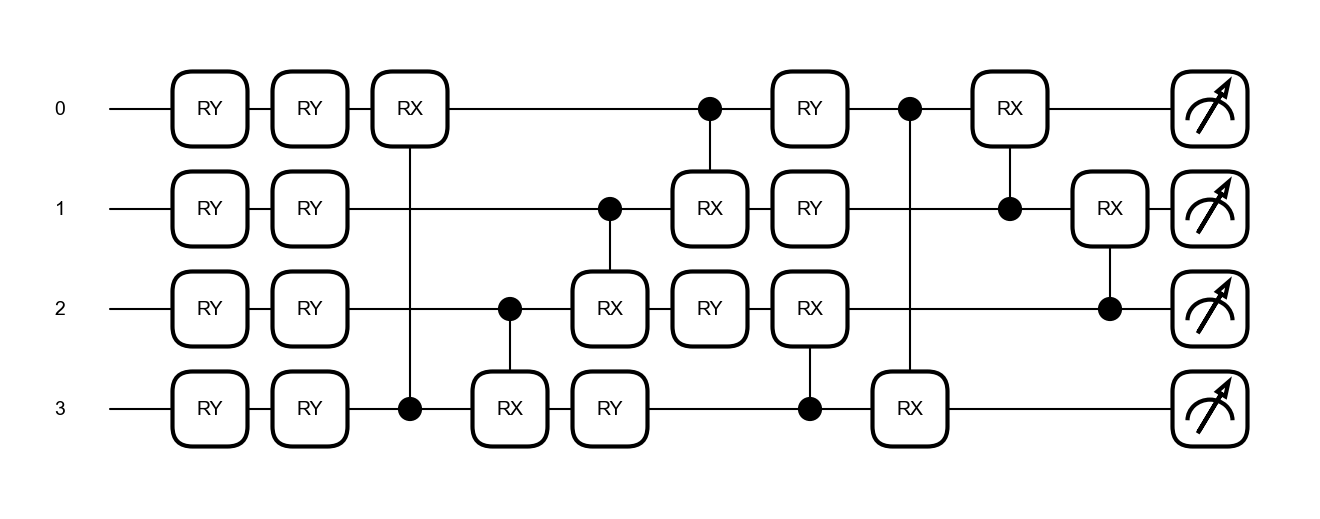

In [46]:
quanv.draw()

In [47]:
print(quanv(train_images[199]).shape)

(16, 16, 4)


## Training
We first initialize an instance of the model, then we train and validate it with the dataset that has been already pre-processed by a quantum convolution.

In [48]:

print(train_images.shape)
print(train_labels.shape)
y_trains = one_hot_encoding[train_labels]
y_trains[0]

(500, 32, 32, 1)
(500,)


array([0., 0., 0., 1., 0., 0.], dtype=float32)

In [51]:
def train(model, train_images, y_train, epochs=10):
    print("Starting Training for {} epochs".format(epochs))

      
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.5)
    m = tf.keras.metrics.Accuracy('accuracy')
    
    
    losses = np.array([])
    accuracy = np.array([])
    batch_size = 4

    for epoch in range(epochs):
        for i, x in enumerate(train_images):

            # prepare inputs and labels
            
            y = np.resize(y_train[i], [16,6])
            
            with tf.GradientTape() as tape:
                   
                # Run the forward pass of the layer.
                # The operations that the layer applies
                # to its inputs are going to be recorded
                # on the GradientTape.

                y_pred = model(x)
                
                loss_value = loss_fn(y_pred, y)

                # Use the gradient tape to automatically retrieve
                # the gradients of the trainable variables with respect to the loss.
                grads = tape.gradient(loss_value, model.trainable_weights)

                # Run one step of gradient descent by updating
                # the value of the variables to minimize the loss.
                optimizer.apply_gradients(zip(grads, model.trainable_weights))


                # output
                
                m.update_state([y_pred], [y])
                acc = m.result()
                
                accuracy = np.append(accuracy, acc)
                losses = np.append(losses, loss_value)

                print("Epoch:", epoch,
                      "\tStep:", i, 
                      "\tAcc:", acc, 
                      "\tLoss:", loss_value
                      )
                        
                       
                print("\nGradients Layer 0:")
                print(model.trainable_weights[0])

                
                print("-------------------------------------------------------\n")

            
    return model, losses, accuracy

Starting Training for 1 epochs
Epoch: 0 	Step: 0 	Acc: tf.Tensor(0.0, shape=(), dtype=float32) 	Loss: tf.Tensor(13.440175, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 1 	Acc: tf.Tensor(0.33333334, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------

Epoch: 0 	Step: 10 	Acc: tf.Tensor(0.6060606, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 11 	Acc: tf.Tensor(0.6111111, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------

Epoch: 0 	Step: 20 	Acc: tf.Tensor(0.6507937, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 21 	Acc: tf.Tensor(0.6515151, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------

Epoch: 0 	Step: 30 	Acc: tf.Tensor(0.67741936, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 31 	Acc: tf.Tensor(0.6770833, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
------------------------------

Epoch: 0 	Step: 40 	Acc: tf.Tensor(0.6910569, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 41 	Acc: tf.Tensor(0.6904762, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------

Epoch: 0 	Step: 50 	Acc: tf.Tensor(0.6928105, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 51 	Acc: tf.Tensor(0.6923077, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------

Epoch: 0 	Step: 60 	Acc: tf.Tensor(0.6939891, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 61 	Acc: tf.Tensor(0.6935484, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------

Epoch: 0 	Step: 70 	Acc: tf.Tensor(0.69483566, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 71 	Acc: tf.Tensor(0.6944444, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
------------------------------

Epoch: 0 	Step: 80 	Acc: tf.Tensor(0.69135803, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 81 	Acc: tf.Tensor(0.6910569, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
------------------------------

Epoch: 0 	Step: 90 	Acc: tf.Tensor(0.6923077, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 91 	Acc: tf.Tensor(0.692029, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
--------------------------------

Epoch: 0 	Step: 100 	Acc: tf.Tensor(0.6930693, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 101 	Acc: tf.Tensor(0.6928105, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-----------------------------

Epoch: 0 	Step: 110 	Acc: tf.Tensor(0.6966967, shape=(), dtype=float32) 	Loss: tf.Tensor(1.192093e-07, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 111 	Acc: tf.Tensor(0.6994048, shape=(), dtype=float32) 	Loss: tf.Tensor(1.192093e-07, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-----------------------

Epoch: 0 	Step: 120 	Acc: tf.Tensor(0.6997245, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 121 	Acc: tf.Tensor(0.69945353, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
----------------------------

Epoch: 0 	Step: 130 	Acc: tf.Tensor(0.7048346, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 131 	Acc: tf.Tensor(0.70454544, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
----------------------------

Epoch: 0 	Step: 140 	Acc: tf.Tensor(0.7068558, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 141 	Acc: tf.Tensor(0.7089202, shape=(), dtype=float32) 	Loss: tf.Tensor(1.192093e-07, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
--------------------------

Epoch: 0 	Step: 150 	Acc: tf.Tensor(0.70640177, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 151 	Acc: tf.Tensor(0.7083333, shape=(), dtype=float32) 	Loss: tf.Tensor(1.192093e-07, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------

Epoch: 0 	Step: 160 	Acc: tf.Tensor(0.70600414, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 161 	Acc: tf.Tensor(0.7057613, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
----------------------------

Epoch: 0 	Step: 170 	Acc: tf.Tensor(0.70955163, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 171 	Acc: tf.Tensor(0.7093023, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
----------------------------

Epoch: 0 	Step: 180 	Acc: tf.Tensor(0.70902395, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 181 	Acc: tf.Tensor(0.7087912, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
----------------------------

Epoch: 0 	Step: 190 	Acc: tf.Tensor(0.70855147, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 191 	Acc: tf.Tensor(0.7083333, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
----------------------------

Epoch: 0 	Step: 200 	Acc: tf.Tensor(0.7097844, shape=(), dtype=float32) 	Loss: tf.Tensor(1.192093e-07, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 201 	Acc: tf.Tensor(0.70957094, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------

Epoch: 0 	Step: 210 	Acc: tf.Tensor(0.7093207, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 211 	Acc: tf.Tensor(0.7091195, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-----------------------------

Epoch: 0 	Step: 220 	Acc: tf.Tensor(0.71040726, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 221 	Acc: tf.Tensor(0.7102102, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
----------------------------

Epoch: 0 	Step: 230 	Acc: tf.Tensor(0.7099567, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 231 	Acc: tf.Tensor(0.70977014, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
----------------------------

Epoch: 0 	Step: 240 	Acc: tf.Tensor(0.7095436, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 241 	Acc: tf.Tensor(0.7093664, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-----------------------------

Epoch: 0 	Step: 250 	Acc: tf.Tensor(0.7118194, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 251 	Acc: tf.Tensor(0.71164024, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
----------------------------

Epoch: 0 	Step: 260 	Acc: tf.Tensor(0.7100894, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 261 	Acc: tf.Tensor(0.71119595, shape=(), dtype=float32) 	Loss: tf.Tensor(1.192093e-07, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------

Epoch: 0 	Step: 270 	Acc: tf.Tensor(0.7109471, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 271 	Acc: tf.Tensor(0.7120098, shape=(), dtype=float32) 	Loss: tf.Tensor(1.192093e-07, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
--------------------------

Epoch: 0 	Step: 280 	Acc: tf.Tensor(0.7117438, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 281 	Acc: tf.Tensor(0.7115839, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-----------------------------

Epoch: 0 	Step: 290 	Acc: tf.Tensor(0.7101947, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 291 	Acc: tf.Tensor(0.71004564, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
----------------------------

Epoch: 0 	Step: 300 	Acc: tf.Tensor(0.7109634, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 301 	Acc: tf.Tensor(0.7108168, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-----------------------------

Epoch: 0 	Step: 310 	Acc: tf.Tensor(0.71168274, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 311 	Acc: tf.Tensor(0.71153843, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
---------------------------

Epoch: 0 	Step: 320 	Acc: tf.Tensor(0.7113188, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 321 	Acc: tf.Tensor(0.7122153, shape=(), dtype=float32) 	Loss: tf.Tensor(1.192093e-07, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
--------------------------

Epoch: 0 	Step: 330 	Acc: tf.Tensor(0.71299094, shape=(), dtype=float32) 	Loss: tf.Tensor(1.192093e-07, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 331 	Acc: tf.Tensor(0.7128514, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------

Epoch: 0 	Step: 340 	Acc: tf.Tensor(0.71163243, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 341 	Acc: tf.Tensor(0.711501, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-----------------------------

Epoch: 0 	Step: 350 	Acc: tf.Tensor(0.71035135, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 351 	Acc: tf.Tensor(0.71022725, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
---------------------------

Epoch: 0 	Step: 360 	Acc: tf.Tensor(0.70914125, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 361 	Acc: tf.Tensor(0.70902395, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
---------------------------

Epoch: 0 	Step: 370 	Acc: tf.Tensor(0.7079964, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 371 	Acc: tf.Tensor(0.7078853, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-----------------------------

Epoch: 0 	Step: 380 	Acc: tf.Tensor(0.70866144, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 381 	Acc: tf.Tensor(0.70855147, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
---------------------------

Epoch: 0 	Step: 390 	Acc: tf.Tensor(0.71014494, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 391 	Acc: tf.Tensor(0.710034, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-----------------------------

Epoch: 0 	Step: 400 	Acc: tf.Tensor(0.7098919, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 401 	Acc: tf.Tensor(0.7097844, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-----------------------------

Epoch: 0 	Step: 410 	Acc: tf.Tensor(0.70965123, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 411 	Acc: tf.Tensor(0.7095469, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
----------------------------

Epoch: 0 	Step: 420 	Acc: tf.Tensor(0.709422, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 421 	Acc: tf.Tensor(0.7093207, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
------------------------------

Epoch: 0 	Step: 430 	Acc: tf.Tensor(0.70843, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 431 	Acc: tf.Tensor(0.7083333, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------

Epoch: 0 	Step: 440 	Acc: tf.Tensor(0.70823884, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 441 	Acc: tf.Tensor(0.7081448, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
----------------------------

Epoch: 0 	Step: 450 	Acc: tf.Tensor(0.70879525, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 451 	Acc: tf.Tensor(0.7094395, shape=(), dtype=float32) 	Loss: tf.Tensor(1.192093e-07, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------

Epoch: 0 	Step: 460 	Acc: tf.Tensor(0.7093276, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 461 	Acc: tf.Tensor(0.7092352, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-----------------------------

Epoch: 0 	Step: 470 	Acc: tf.Tensor(0.7098372, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 471 	Acc: tf.Tensor(0.70974576, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
----------------------------

Epoch: 0 	Step: 480 	Acc: tf.Tensor(0.7103257, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 481 	Acc: tf.Tensor(0.7102351, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-----------------------------

Epoch: 0 	Step: 490 	Acc: tf.Tensor(0.71079427, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 491 	Acc: tf.Tensor(0.7113821, shape=(), dtype=float32) 	Loss: tf.Tensor(1.192093e-07, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(16,) dtype=float32, numpy=
array([ 0.1801252 ,  0.42043725, -0.03063461,  0.14538911, -0.20283243,
        0.12061986, -0.25782818, -0.11285317,  0.29702106, -0.28326806,
       -0.02763793,  0.17738768,  0.2507535 , -0.08260208,  0.29155925,
       -0.09267348], dtype=float32)>
-------------------------

Text(0, 0.5, 'Accuracy')

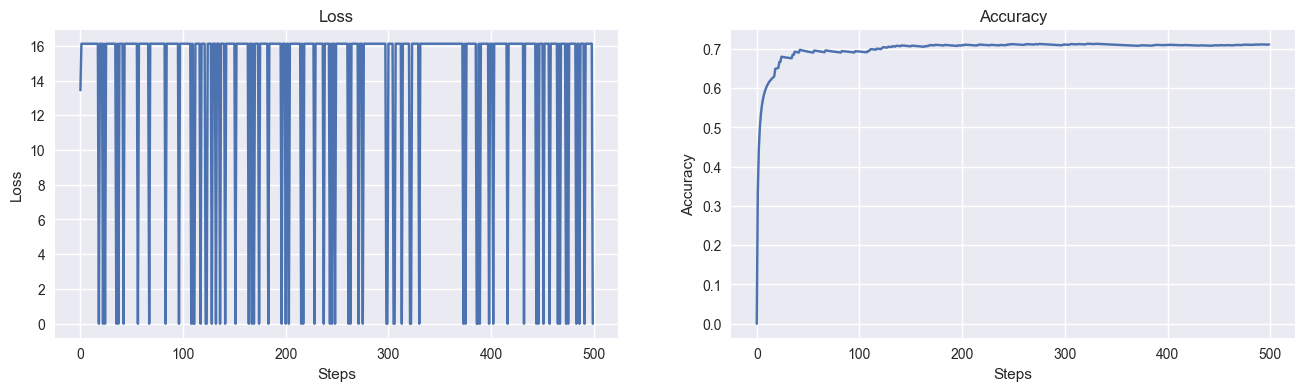

In [52]:
# build the model

model = keras.models.Sequential([
        
    QuanvLayer_circuit14(stride=2, circuit_layers=1, n_rotations=16, out_channels=4),
        
    keras.layers.Flatten(),
        
    keras.layers.Dense(1024, activation="relu"),
    keras.layers.Dropout(0.4),
        
    keras.layers.Dense(len(labels), activation="softmax")
])

model.compile(
        optimizer='adam',
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
     
# start training
model, losses, accs = train(model, train_images, y_trains, epochs=1)

# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4))
ax1.plot(losses)
ax1.set_title("Loss")
ax1.set_xlabel("Steps")
ax1.set_ylabel("Loss")

ax2.plot(accs)
ax2.set_title("Accuracy")
ax2.set_xlabel("Steps")
ax2.set_ylabel("Accuracy")
    

## Quanvolutional Layer Using Circuit Block (CB)

In [58]:
class QuanvLayer_circuit_CB(keras.layers.Layer):
    def __init__(self, stride=2, device="default.qubit", wires=4, circuit_layers=1, n_rotations=20, out_channels=4):
        super(QuanvLayer_circuit_CB, self).__init__()
        
        # init device
        self.wires = wires
        self.dev = qml.device(device, wires=self.wires)
        
        self.stride = stride
        self.out_channels = min(out_channels, wires)
        
            
        # Parameterized Quantum circuits
        @qml.qnode(device=self.dev, interface ="tf")
                
        def circuit(inputs, weights):
            
            n_inputs=4
            # Encoding of 4 classical input values
            for j in range(n_inputs):
                qml.RY(np.pi * float(inputs[j])/255, wires=j)
            
                                          
            # Quantum circuit 14
            for i in range(n_inputs):
                qml.RX(weights, wires=i)
                qml.RZ(weights, wires=i)
                
            qml.CRX(weights, wires=[3, 0])
            qml.CRX(weights, wires=[2, 3])
            qml.CRX(weights, wires =[1,2])
            qml.CRX(weights, wires =[0,1])
            
            qml.CRX(weights, wires=[3, 0])
            qml.CRX(weights, wires=[2, 3])
            qml.CRX(weights, wires =[1,2])
            qml.CRX(weights, wires =[0,1])
            
            qml.CRX(weights, wires=[3, 0])
            qml.CRX(weights, wires=[2, 3])
            qml.CRX(weights, wires =[1,2])
            qml.CRX(weights, wires =[0,1])
                        
            # Measurement producing 4 classical output values
            return [qml.expval(qml.PauliZ(j)) for j in range(self.out_channels)]
        
        weight_shapes = {"weights": [n_rotations]}
        self.circuit = qml.qnn.KerasLayer(circuit, weight_shapes = weight_shapes, output_dim = out_channels)  
        
        
           
    def draw(self):
        # build circuit by sending dummy data through it
        drawer = qml.draw_mpl(self.circuit)
        print(drawer(inputs=tf.convert_to_tensor(np.zeros(4))))
        
        

    def call(self, img):
        h, w, ch = img.shape
        if ch > 1:
            img = img.mean(axis=-1).reshape(h, w, 1)
                        
        kernel_size = 2        
        h_out = (h-kernel_size) // self.stride + 1
        w_out = (w-kernel_size) // self.stride + 1
        
        
        out = np.zeros((h_out, w_out, self.out_channels))
        
        # Loop over the coordinates of the top-left pixel of 2X2 squares
        for j in range(0, h_out, self.stride):
            for k in range(0, w_out, self.stride):
                # Process a squared 2x2 region of the image with a quantum circuit
                q_results = self.circuit(tf.convert_to_tensor(
                    [
                        img[j, k, 0],
                        img[j, k + 1, 0],
                        img[j + 1, k, 0],
                        img[j + 1, k + 1, 0]
                        ])
                                         )
                
                # Assign expectation values to different channels of the output pixel (j/2, k/2)
                for c in range(self.out_channels):
                    out[j // kernel_size, k // kernel_size, c] = q_results[c]
                
        return out
  

In [59]:
# Test QuanvLayer

quanv = QuanvLayer_circuit_CB(circuit_layers=1, n_rotations=20, out_channels=4, stride=2)

x = np.random.rand(32,32,1)
print(x.shape)
# Check OonvLayer Output shape
quanv(x).shape

(32, 32, 1)


(16, 16, 4)

(<Figure size 1800x500 with 1 Axes>, <Axes: >)


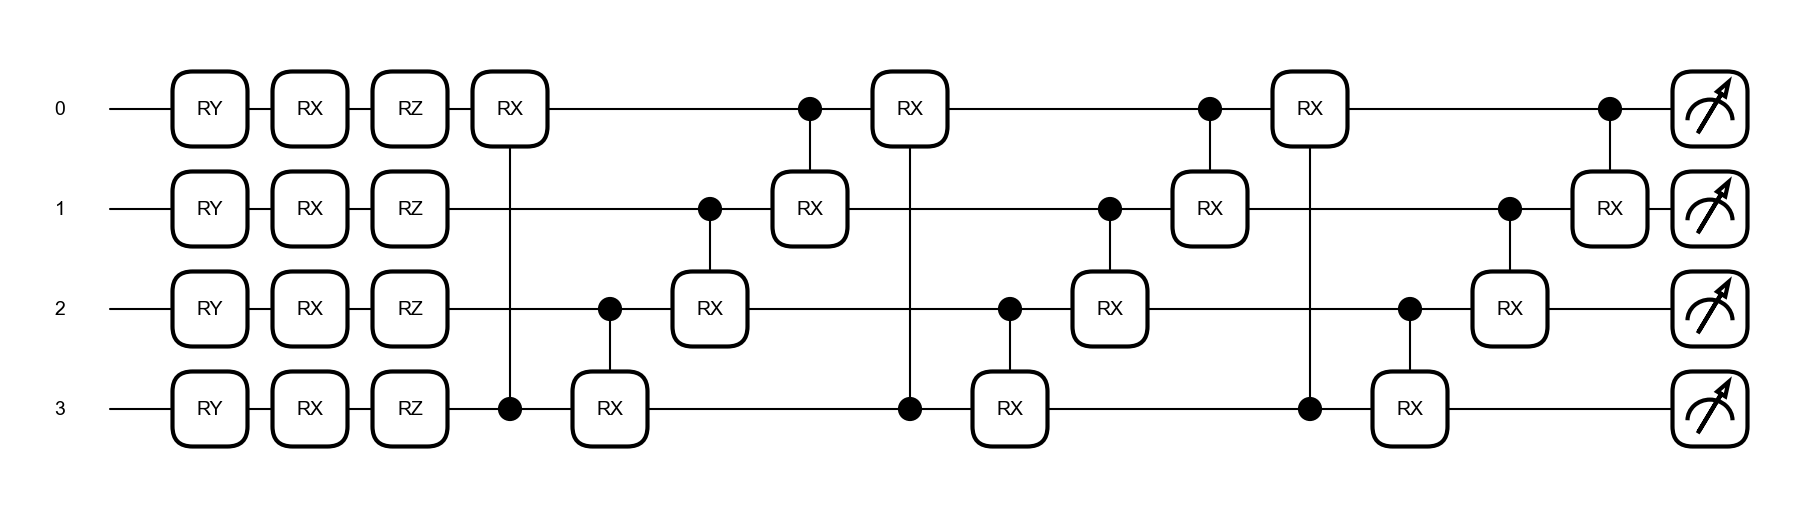

In [60]:
quanv.draw()

In [61]:
def train(model, train_images, y_train, epochs=10):
    print("Starting Training for {} epochs".format(epochs))

      
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.5)
    m = tf.keras.metrics.Accuracy('accuracy')
    
    
    losses = np.array([])
    accuracy = np.array([])
    batch_size = 4

    for epoch in range(epochs):
        for i, x in enumerate(train_images):

            # prepare inputs and labels
            
            y = np.resize(y_train[i], [16,6])
            
            with tf.GradientTape() as tape:
                   
                # Run the forward pass of the layer.
                # The operations that the layer applies
                # to its inputs are going to be recorded
                # on the GradientTape.

                y_pred = model(x)
                
                loss_value = loss_fn(y_pred, y)

                # Use the gradient tape to automatically retrieve
                # the gradients of the trainable variables with respect to the loss.
                grads = tape.gradient(loss_value, model.trainable_weights)

                # Run one step of gradient descent by updating
                # the value of the variables to minimize the loss.
                optimizer.apply_gradients(zip(grads, model.trainable_weights))


                # output
                
                m.update_state([y_pred], [y])
                acc = m.result()
                
                accuracy = np.append(accuracy, acc)
                losses = np.append(losses, loss_value)

                print("Epoch:", epoch,
                      "\tStep:", i, 
                      "\tAcc:", acc, 
                      "\tLoss:", loss_value
                      )
                        
                       
                print("\nGradients Layer 0:")
                print(model.trainable_weights[0])

                
                print("-------------------------------------------------------\n")

            
    return model, losses, accuracy

Starting Training for 1 epochs
Epoch: 0 	Step: 0 	Acc: tf.Tensor(0.0, shape=(), dtype=float32) 	Loss: tf.Tensor(13.416136, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 1 	Acc: tf.Tensor(0.33333334, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,

Epoch: 0 	Step: 9 	Acc: tf.Tensor(0.6, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 10 	Acc: tf.Tensor(0.6060606, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.0230340

Epoch: 0 	Step: 18 	Acc: tf.Tensor(0.64912283, shape=(), dtype=float32) 	Loss: tf.Tensor(1.192093e-07, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 19 	Acc: tf.Tensor(0.65, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.0

Epoch: 0 	Step: 27 	Acc: tf.Tensor(0.6785714, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 28 	Acc: tf.Tensor(0.6781609, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.

Epoch: 0 	Step: 36 	Acc: tf.Tensor(0.6846847, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 37 	Acc: tf.Tensor(0.69298244, shape=(), dtype=float32) 	Loss: tf.Tensor(1.192093e-07, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
      

Epoch: 0 	Step: 45 	Acc: tf.Tensor(0.6956522, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 46 	Acc: tf.Tensor(0.69503546, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0

Epoch: 0 	Step: 54 	Acc: tf.Tensor(0.6909091, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 55 	Acc: tf.Tensor(0.6904762, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.

Epoch: 0 	Step: 63 	Acc: tf.Tensor(0.6927083, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 64 	Acc: tf.Tensor(0.6923077, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.

Epoch: 0 	Step: 72 	Acc: tf.Tensor(0.6940639, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 73 	Acc: tf.Tensor(0.6936937, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.

Epoch: 0 	Step: 81 	Acc: tf.Tensor(0.6910569, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 82 	Acc: tf.Tensor(0.69076306, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0

Epoch: 0 	Step: 90 	Acc: tf.Tensor(0.6923077, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 91 	Acc: tf.Tensor(0.692029, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.0

Epoch: 0 	Step: 99 	Acc: tf.Tensor(0.6933333, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 100 	Acc: tf.Tensor(0.6930693, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0

Epoch: 0 	Step: 108 	Acc: tf.Tensor(0.6941896, shape=(), dtype=float32) 	Loss: tf.Tensor(1.192093e-07, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 109 	Acc: tf.Tensor(0.6939394, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
     

Epoch: 0 	Step: 117 	Acc: tf.Tensor(0.700565, shape=(), dtype=float32) 	Loss: tf.Tensor(1.192093e-07, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 118 	Acc: tf.Tensor(0.70028013, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
     

Epoch: 0 	Step: 126 	Acc: tf.Tensor(0.70341206, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 127 	Acc: tf.Tensor(0.703125, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        

Epoch: 0 	Step: 135 	Acc: tf.Tensor(0.7058824, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 136 	Acc: tf.Tensor(0.7080292, shape=(), dtype=float32) 	Loss: tf.Tensor(1.192093e-07, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
     

Epoch: 0 	Step: 144 	Acc: tf.Tensor(0.70804596, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 145 	Acc: tf.Tensor(0.70776254, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
      

Epoch: 0 	Step: 153 	Acc: tf.Tensor(0.7077922, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 154 	Acc: tf.Tensor(0.70752686, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
       

Epoch: 0 	Step: 162 	Acc: tf.Tensor(0.70552146, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 163 	Acc: tf.Tensor(0.70528454, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
      

Epoch: 0 	Step: 171 	Acc: tf.Tensor(0.7093023, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 172 	Acc: tf.Tensor(0.7090559, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        

Epoch: 0 	Step: 180 	Acc: tf.Tensor(0.70902395, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 181 	Acc: tf.Tensor(0.7087912, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
       

Epoch: 0 	Step: 189 	Acc: tf.Tensor(0.70877194, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 190 	Acc: tf.Tensor(0.70855147, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
      

Epoch: 0 	Step: 198 	Acc: tf.Tensor(0.7085427, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 199 	Acc: tf.Tensor(0.7083333, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        

Epoch: 0 	Step: 207 	Acc: tf.Tensor(0.7099359, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 208 	Acc: tf.Tensor(0.7097289, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        

Epoch: 0 	Step: 216 	Acc: tf.Tensor(0.7096774, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 217 	Acc: tf.Tensor(0.71100914, shape=(), dtype=float32) 	Loss: tf.Tensor(1.192093e-07, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
    

Epoch: 0 	Step: 225 	Acc: tf.Tensor(0.7094395, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 226 	Acc: tf.Tensor(0.7092511, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        

Epoch: 0 	Step: 234 	Acc: tf.Tensor(0.7092199, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 235 	Acc: tf.Tensor(0.70903957, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
       

Epoch: 0 	Step: 243 	Acc: tf.Tensor(0.7103825, shape=(), dtype=float32) 	Loss: tf.Tensor(1.192093e-07, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 244 	Acc: tf.Tensor(0.71020406, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
    

Epoch: 0 	Step: 252 	Acc: tf.Tensor(0.71146244, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 253 	Acc: tf.Tensor(0.71128607, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
      

Epoch: 0 	Step: 261 	Acc: tf.Tensor(0.71119595, shape=(), dtype=float32) 	Loss: tf.Tensor(1.192093e-07, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 262 	Acc: tf.Tensor(0.7110266, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
    

Epoch: 0 	Step: 270 	Acc: tf.Tensor(0.7109471, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 271 	Acc: tf.Tensor(0.7120098, shape=(), dtype=float32) 	Loss: tf.Tensor(1.192093e-07, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
     

Epoch: 0 	Step: 279 	Acc: tf.Tensor(0.71190476, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 280 	Acc: tf.Tensor(0.7117438, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
       

Epoch: 0 	Step: 288 	Acc: tf.Tensor(0.71049595, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 289 	Acc: tf.Tensor(0.71034485, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
      

Epoch: 0 	Step: 297 	Acc: tf.Tensor(0.70917225, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 298 	Acc: tf.Tensor(0.71014494, shape=(), dtype=float32) 	Loss: tf.Tensor(1.192093e-07, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
   

Epoch: 0 	Step: 306 	Acc: tf.Tensor(0.71226925, shape=(), dtype=float32) 	Loss: tf.Tensor(1.192093e-07, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 307 	Acc: tf.Tensor(0.7121212, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
    

Epoch: 0 	Step: 315 	Acc: tf.Tensor(0.71202534, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 316 	Acc: tf.Tensor(0.71188223, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
      

Epoch: 0 	Step: 324 	Acc: tf.Tensor(0.71282053, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 325 	Acc: tf.Tensor(0.7126789, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
       

Epoch: 0 	Step: 333 	Acc: tf.Tensor(0.71257484, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 334 	Acc: tf.Tensor(0.7124378, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
       

Epoch: 0 	Step: 342 	Acc: tf.Tensor(0.7113703, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 343 	Acc: tf.Tensor(0.7112403, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        

Epoch: 0 	Step: 351 	Acc: tf.Tensor(0.71022725, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 352 	Acc: tf.Tensor(0.71010387, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
      

Epoch: 0 	Step: 360 	Acc: tf.Tensor(0.70914125, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 361 	Acc: tf.Tensor(0.70902395, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
      

Epoch: 0 	Step: 369 	Acc: tf.Tensor(0.7081081, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 370 	Acc: tf.Tensor(0.7079964, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        

Epoch: 0 	Step: 378 	Acc: tf.Tensor(0.70888305, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 379 	Acc: tf.Tensor(0.70877194, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
      

Epoch: 0 	Step: 387 	Acc: tf.Tensor(0.70962197, shape=(), dtype=float32) 	Loss: tf.Tensor(1.192093e-07, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 388 	Acc: tf.Tensor(0.7095116, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
    

Epoch: 0 	Step: 396 	Acc: tf.Tensor(0.7094878, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 397 	Acc: tf.Tensor(0.7093802, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        

Epoch: 0 	Step: 405 	Acc: tf.Tensor(0.71018064, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 406 	Acc: tf.Tensor(0.7100737, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
       

Epoch: 0 	Step: 414 	Acc: tf.Tensor(0.7092369, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 415 	Acc: tf.Tensor(0.70913464, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
       

Epoch: 0 	Step: 423 	Acc: tf.Tensor(0.7091195, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 424 	Acc: tf.Tensor(0.7090196, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        

Epoch: 0 	Step: 432 	Acc: tf.Tensor(0.7090069, shape=(), dtype=float32) 	Loss: tf.Tensor(1.192093e-07, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 433 	Acc: tf.Tensor(0.7089094, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
     

Epoch: 0 	Step: 441 	Acc: tf.Tensor(0.7081448, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 442 	Acc: tf.Tensor(0.70805115, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
       

Epoch: 0 	Step: 450 	Acc: tf.Tensor(0.70879525, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 451 	Acc: tf.Tensor(0.7094395, shape=(), dtype=float32) 	Loss: tf.Tensor(1.192093e-07, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
    

Epoch: 0 	Step: 459 	Acc: tf.Tensor(0.70942026, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 460 	Acc: tf.Tensor(0.7093276, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
       

Epoch: 0 	Step: 468 	Acc: tf.Tensor(0.7100213, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 469 	Acc: tf.Tensor(0.70992905, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
       

Epoch: 0 	Step: 477 	Acc: tf.Tensor(0.7105997, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 478 	Acc: tf.Tensor(0.710508, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0

Epoch: 0 	Step: 486 	Acc: tf.Tensor(0.7111567, shape=(), dtype=float32) 	Loss: tf.Tensor(1.192093e-07, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 487 	Acc: tf.Tensor(0.7110656, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
     

Epoch: 0 	Step: 495 	Acc: tf.Tensor(0.7110215, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
        0.02303401, -0.08421022,  0.05873913,  0.1936804 , -0.10522845],
      dtype=float32)>
-------------------------------------------------------

Epoch: 0 	Step: 496 	Acc: tf.Tensor(0.71093225, shape=(), dtype=float32) 	Loss: tf.Tensor(16.118095, shape=(), dtype=float32)

Gradients Layer 0:
<tf.Variable 'weights:0' shape=(20,) dtype=float32, numpy=
array([-0.10669002, -0.35028595, -0.26542032,  0.03967941, -0.1378527 ,
       -0.3475952 ,  0.36226374,  0.04210368,  0.15813363, -0.2415983 ,
        0.04325238,  0.01882869, -0.10961005, -0.3572067 ,  0.29535723,
       

Text(0, 0.5, 'Accuracy')

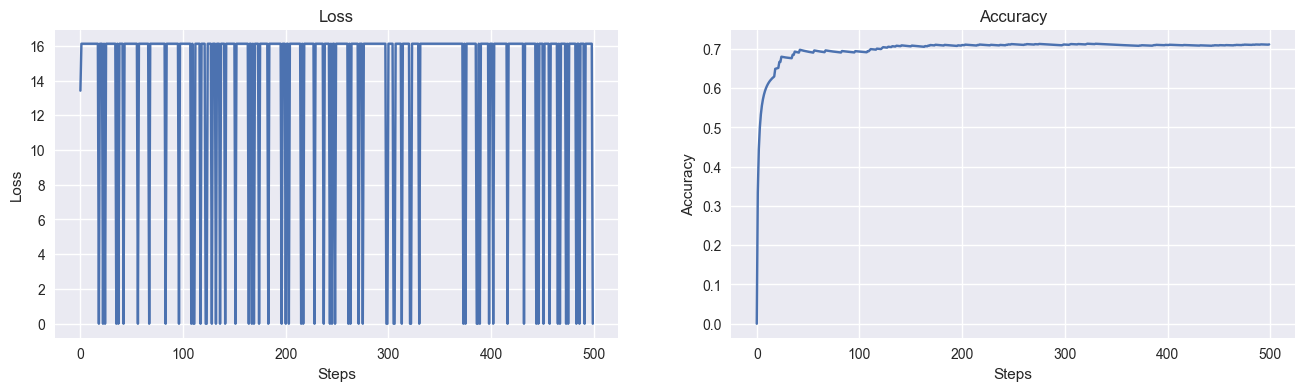

In [62]:
# build the model

model = keras.models.Sequential([
        
    QuanvLayer_circuit_CB(stride=2, circuit_layers=1, n_rotations=20, out_channels=4),
        
    keras.layers.Flatten(),
        
    keras.layers.Dense(1024, activation="relu"),
    keras.layers.Dropout(0.4),
        
    keras.layers.Dense(len(labels), activation="softmax")
])

model.compile(
        optimizer='adam',
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
     
# start training
model, losses, accs = train(model, train_images, y_trains, epochs=1)

# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4))
ax1.plot(losses)
ax1.set_title("Loss")
ax1.set_xlabel("Steps")
ax1.set_ylabel("Loss")

ax2.plot(accs)
ax2.set_title("Accuracy")
ax2.set_xlabel("Steps")
ax2.set_ylabel("Accuracy")
    

## References
[1] Maxwell Henderson, Samriddhi Shakya, Shashindra Pradhan, Tristan Cook. “Quanvolutional Neural Networks: Powering Image Recognition with Quantum Circuits.” arXiv:1904.04767, 2019.

[2] T. Hur,L.Kim, and Daniel K. Park. “Quantum convolutional neural network for classical data classification.” arXiv:2108.00661v2, Feb, 2022.

[3] https://www.fokus.fraunhofer.de and https://www.planqk.de.

[4] S. Sim, Peter D. Johnson, and Alán Aspuru-Guzik, “Expressibility and entangling capability of parameterized quantum circuits for hybrid quantum-classical algorithms.” arXiv:1905.10876v1, May 2019.

